In [149]:
import os
# import pandas as pd 
import polars as pl
# import scanpy as sc
import numpy as np
import typing as tp
import re
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
import seaborn as sns; sns.set_style("white")
import umap as umap
# import hdbscan as hdb

# import plotnine as gg
# from cytominer_eval import evaluate

# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D/spher_colo52_v1
/share/data/analyses/christa/colopaint3D/spher_colo52_v1


In [150]:
# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D/spher_colo52_v1
/share/data/analyses/christa/colopaint3D/spher_colo52_v1


In [151]:

# Sorry!
import pandas as pd

In [152]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [153]:
# figformat = 'png'
# dpi = 300
# statarg = 'single'
# OutputDir = f'./data/2_PCAUMAP'
# if not os.path.exists(OutputDir): 
#     os.makedirs(OutputDir)
# FeatureDir = './data/1_FeaturesImages_meanstd_PerPlate'


In [154]:
# filenames = ['HCT116_MedianAgg_meanstd']
# # filenames = ['HCT116_MeanAgg_medianmad']
# # filenames = ['HT29_MeanAgg_medianmad']
# # filenames = ['HT29_MedianAgg_meanstd']
# # statmet = 'SingleSlice'
# # statmet = 'prototype'
# statmet = 'WellAggregates'
# # statmet = 'SingleCell'
# # filenames = ['HCT116_MedianAgg_meanstd_prototype_slice_selected']
# # filenames = ['HT29_mad']
# # filenames = ['HT29_mean']
# # filenames = ['HCT116_mad']
# # filenames = ['HCT116_mean']
# # filenames = ['HCT116_Slice3MeanAgg_medianmad']
# # filenames = ['HCT116_Slice3MedianAgg_meanstd']
# # filenames = ['HT29_Slice3MeanAgg_medianmad']
# # filenames = ['HT29_Slice3MedianAgg_meanstd']
# statmets = ['SingleCell', 'Aggregates']

# dropcols = ['Nuclei_Location_Center_X',
#             'Nuclei_Location_Center_Y',
#             'Location',
#             'ImageNumber_',
#             'Parent',
#             'Children',
#             '_ObjectNumber',
#             '_Object_Number',
#             '_Y',
#             '_X' 
#             ]


# cons = ['pos_con', 'neg_con']
# nodmso = ['trt']
# wdmso = ['pos_con']
float_columns=[pl.col(pl.Float32),pl.col(pl.Float64)]

# ##### Correlation contains some kind of well information
# # feature_groups = ['AreaShape'
# #                   , 'Correlation'
# #                   , 'Granularity'
# #                   , 'Intensity'
# #                   , 'Neighbors'
# #                   , 'RadialDistribution'
# #                   ]
# # real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# # training_data = training_data[real_names]

In [155]:
def readData(filename, statmet='SingleCell'):
    df = pl.read_parquet(f'{FeatureDir}/{statmet}/{filename}.parquet')
    ##This here is important!!!!!!
    # df=df.select([c for c in df.columns if not is_meta_column(c)])
    # dataNpy = df.to_numpy(df.select(float_columns))
    ##
    onehot_list = df.select(['Metadata_cmpd_pathway'])['Metadata_cmpd_pathway'].unique().to_list()
    onehot_mapping = {name: i for i, name in enumerate(onehot_list)}
    df = df.with_columns(df['Metadata_cmpd_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_onehot'))
    return df

# this is code from Dan
def is_meta_column(
    c:str,
    allowlist:tp.List[str]=["Metadata_Well","Metadata_Barcode","Metadata_AcqID","Metadata_Site"],
    denylist:tp.List[str]=[],
)->bool:
    """
        allowlist:
            the function will return False for these, no matter if they are metadata or not
        denylist:
            the function will return True for these, no matter if they are metadata or not
    """
    if c in allowlist:
        return False
    if c in denylist:
        return True
    for ex in '''
        Metadata
        ^Count
        ImageNumber
        Object
        Parent
        Children
        Plate
        Well
        Location
        _[XYZ]_
        _[XYZ]$
        BoundingBox
        Phase
        Orientation
        Angle
        Scale
        Scaling
        Width
        Height
        Group
        FileName
        PathName
        URL
        Execution
        ModuleError
        LargeBrightArtefact
        MD5Digest
        RadialDistribution_Frac
        Intensity_
        _Manders
        _Overflow
    '''.split():
        if re.search(ex, c):
            return True
    return False

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    return list_of_selected_features, list_of_metadata

def oneHot(row, mapping):
    return mapping.get(row, -1)

def makePCA(df, name='', statmet='SingleCell' , n_components=2):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    pca_model = PCA(n_components=2)
    pca_model = pca_model.fit(dataN)
    pcaOut = pca_model.transform(dataN)
    df = df.with_columns([
    pl.Series('pc1', pcaOut[:, 0]),  
    pl.Series('pc2', pcaOut[:, 1])   
    ])

    hue = df['Metadata_cmpd_pathway'].to_list()
    cmap = sns.color_palette("tab20", n_colors=len(df['Metadata_cmpd_pathway'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('PC 1', fontsize = 10)
    ax.set_ylabel('PC 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['pc1'].to_list(),
                    y=df['pc2'].to_list(),
                    palette=cmap, hue=hue,
                    marker='.',
                    ).set(title=f'PCA {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()
    return df

def makeUMAP(df, name='', statmet='SingleCell' , nn = 200, is_supervised=True, n_components=100, min_dist=0.1, spread= 5, n_epochs=None, metric='cosine', use_pca=True, lut=None):
    dataN=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns).to_numpy()
    umap_model = umap.UMAP(n_neighbors=nn
                        , min_dist=min_dist
                        , spread= spread
                        , n_epochs=n_epochs
                        , metric=metric
                        , n_jobs=-1
                        )
    if use_pca:
        pca_model = PCA(n_components=n_components)
        pca_model = pca_model.fit(dataN)
        dataN = pca_model.transform(dataN)
        
    if is_supervised:
        umapOut = umap_model.fit_transform(dataN, y=df['Metadata_cmpd_onehot'].to_list())
        isSup = 'Supervised'
    else:
        umapOut = umap_model.fit_transform(dataN)
        isSup = 'Unsupervised'
    df = df.with_columns([
    pl.Series('umap1', umapOut[:, 0]),  
    pl.Series('umap2', umapOut[:, 1])   
    ])

    # hue = df['Metadata_cmpd_pathway'].to_list()
    hue = df['Metadata_pathway'].to_list()
    # cmap = sns.color_palette("tab20", n_colors=len(df['Metadata_cmpd_pathway'].unique().to_list()))
    # cmap = sns.color_palette("tab20", n_colors=len(df['Metadata_pathway'].unique().to_list()))

    fig = plt.figure(
    # figsize=[14, 5]
    )
    ax = fig.add_subplot(111)
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x=df['umap1'].to_list(),
                    y=df['umap2'].to_list(),
                    palette=lut, hue=hue,
                    marker='.',
                    ).set(title=f'umap {name} All'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # if not os.path.exists(f'{OutputDir}/{statmet}'):
    #     os.makedirs(f'{OutputDir}/{statmet}')
    # plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')
    plt.show()
    plt.close()
    return df


In [156]:
cell_line = 'HT29'
data_type = 'MIP'

# Load the data
file = 'selected_data_all.csv'
data = pd.read_csv(file)

dataset = data.query("Metadata_cell_line == @cell_line & Metadata_data_type == @data_type").copy()
dataset = dataset[dataset['Metadata_pert_type'] == 'trt']
dataset = dataset.dropna(axis='columns', how='all')

In [157]:
# # Setup the color palette
# # Create a dictionary of pathways and their associated compounds.
# compounds = dataset['Metadata_name'].unique()
# pathways_dict = {cmpd: data[data['Metadata_name'] == cmpd]['Metadata_pathway'].unique()[0] for cmpd in compounds}

# pathways = pd.Series(pathways_dict).unique()
# pathways = pd.Series(pathways).dropna()
# pathways = pathways[~pathways.isin(['etop', 'dmso', 'stau', 'fenb', 'water', 'sorb'])]
# pathways

# # Create a color map for the pathways
# colors = sns.color_palette('tab20', len(pathways))
# lut = dict(zip(pathways, colors))
# # col_colors = pd.Series(pathways_dict).map(lut)

In [158]:
# pandas to polars
df = pl.DataFrame(dataset)
onehot_list = df.select(['Metadata_pathway'])['Metadata_pathway'].unique().to_list()
onehot_mapping = {name: i for i, name in enumerate(onehot_list)}
df = df.with_columns(df['Metadata_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_onehot'))

/tmp/ipykernel_1694530/1447731236.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df = df.with_columns(df['Metadata_pathway'].map_elements(lambda name: oneHot(name, onehot_mapping)).alias('Metadata_cmpd_onehot'))


/home/jovyan/.local/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


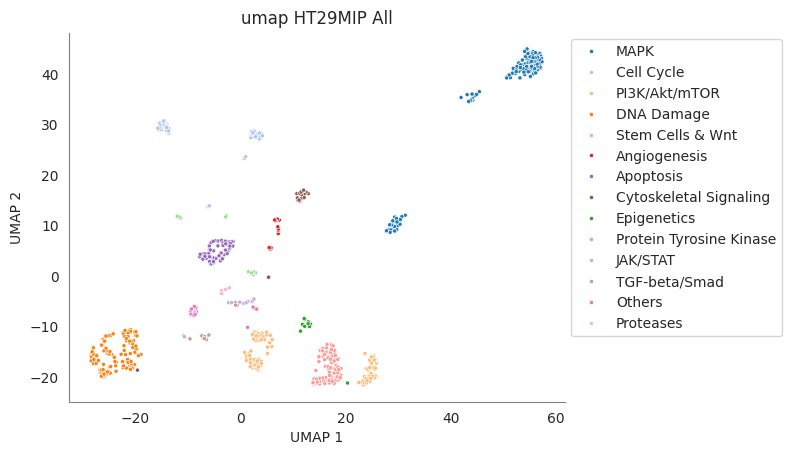

In [159]:
results = makeUMAP(df, name=cell_line+data_type,nn=100, is_supervised=True, use_pca=False, lut=lut)



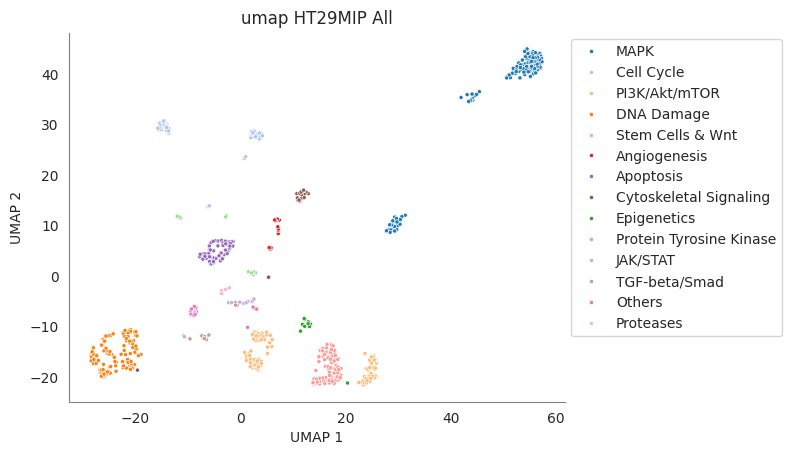

In [160]:
name = cell_line+data_type
hue = results['Metadata_pathway'].to_list()

fig = plt.figure(
# figsize=[14, 5]
)
ax = fig.add_subplot(111)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x=results['umap1'].to_list(),
                y=results['umap2'].to_list(),
                palette=lut,
                hue=hue,
                marker='.',
                ).set(title=f'umap {name} All'
            )
ax.set_facecolor('w')
ax.get_legend().remove()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# if not os.path.exists(f'{OutputDir}/{statmet}'):
#     os.makedirs(f'{OutputDir}/{statmet}')
# plt.savefig(f'{OutputDir}/{statmet}/{name}_umap{nn}nn_{isSup}.png')

fig.savefig(
        "2_PCAUMAP/result-images/UMAP_pathway_{}_{}.{}".format(cell_line, data_type,figformat), dpi=dpi, bbox_inches="tight"
        )

plt.show()
plt.close()

In [161]:
# df = pl.read_parquet(f'{FeatureDir}/{statmet}/{filenames[0]}.parquet')

In [162]:
# df.head()

In [163]:
# df.select(pl.col('Metadata_cmpd_pathway')).to_series().unique().to_list()

In [164]:
# df_nometa=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)

In [165]:
# df_nometa.head()

In [166]:
# filename = filenames[0]
# # df = pl.read_parquet(f'{FeatureDir}/SingleCell/{filename}.parquet')
# df = readData(filename, statmet=statmet)
# # df['Metadata_cmpd_pathway'].unique().to_list()

In [167]:
# df.head()

In [168]:
# # columns_containing_metadata = [col_name for col_name in df.columns if 'Metadata_' in col_name]
# # columns_containing_metadata
# # df2=df.select([c for c in df.columns if not is_meta_column(c)])
# df_floats=df.select([c for c in df.columns if not is_meta_column(c)]).select(float_columns)

# # for c in df.columns:
# #     if is_meta_column(c):
# #         print(c)


In [169]:
# # df2 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(cons))
# # cons = ['pos_con']

# df2 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(cons))
# df3 = df.filter(pl.col('Metadata_cmpd_pert_type').is_in(nodmso))
# df4 = df.filter(~pl.col('Metadata_cmpd_pert_type').is_in(wdmso))

In [170]:
# df.select(pl.col('Metadata_cmpd_pert_type')).to_series().unique()

In [171]:
# df2.shape[0]

In [172]:
# df3.shape[0]

In [173]:
# df4.shape[0]

In [174]:
# num_dmso = df2.filter(pl.col('Metadata_cmpd_pathway')== 'dmso').shape[0]
# num_dmso = int(num_dmso*0.1)
# print(num_dmso)
# dmso_df = df2.filter(pl.col('Metadata_cmpd_pathway')=='dmso').sample(n=num_dmso, seed = 42)

# df5 = df2.filter(~pl.col('Metadata_cmpd_pathway').is_in(['dmso']))

# df5 = pl.concat([df5, dmso_df])
# # df_with_id = df.with_column(pl.arange(0, df.height).alias('unique_id'))
# # mask = pl.col('Metadata_cmpd_pathway').is_not('dmso') | df.join(dmso_rows, on=list(df.columns), how='inner').with_column(pl.lit(True).alias('keep'))

# # print(df5.shape)
# cols = df5['Metadata_cmpd_pathway'].unique().to_list()
# for column in cols:
#     # print(column)
#     print(f"{column}:   {df5.filter(pl.col('Metadata_cmpd_pathway')==column).shape[0]}")

In [175]:
# cols = df3['Metadata_cmpd_pathway'].unique().to_list()
# for column in cols:
#     # print(column)
#     print(f"{column}:   {df3.filter(pl.col('Metadata_cmpd_pathway')==column).shape[0]}")

In [176]:
# df5.head()

### Here we transform only the controls

In [177]:
# _ = makePCA(df5, name=filename)
# # df2 = makeUMAP(df2, name=filename, is_supervised=False, use_pca=False)


In [178]:
# _ = makeUMAP(df5, name=filename, nn=100, is_supervised=False, use_pca=False)

In [179]:
# _ = makeUMAP(df5, name=filename, nn=100, is_supervised=True, use_pca=False)

### Here we transform only the screen

In [180]:
# _ = makePCA(df3, name=filename)

In [181]:
'_ = makeUMAP(df3, name=filename, nn=100, is_supervised=False, use_pca=False)'

'_ = makeUMAP(df3, name=filename, nn=100, is_supervised=False, use_pca=False)'

In [182]:
# _ = makeUMAP(df3, name=filename,nn=100, is_supervised=True, use_pca=False)

### Here we run with active compounds and neg controls

In [183]:
# _ = makePCA(df4, name=filename)

In [184]:
# _ = makeUMAP(df4, name=filename, nn=100, is_supervised=False, use_pca=False)

In [185]:
# _ = makeUMAP(df4, name=filename,nn=100, is_supervised=True, use_pca=False)